In [18]:
import os
print(1)
import torch
print(2)

from transformers import AutoImageProcessor, DinatForImageClassification, TrainingArguments, Trainer
print(3)

from functions_old import *
print(4)

from datasets import load_dataset
print(5)

from torch.utils.data import DataLoader
print(6)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch.optim as optim
from transformers import get_scheduler

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
import torch.nn.functional as F
import logging
from collections import Counter


1
2
3
4
5
6


In [19]:
# Initialize your image model (DINAT) and BERT model separately
# For example, using Hugging Face models:
from transformers import DinatForImageClassification, BertModel
# old_model = "/media/carol/Data/Documents/Emo_rec/Notebooks/NLP_IMG/Ver1/DinatBert/manual_trained_model.pth"
pretrain_model = "/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model"

image_model = DinatForImageClassification.from_pretrained(pretrain_model,num_labels=4,  ignore_mismatched_sizes=True, problem_type = 'single_label_classification').to(device)
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Define the combined model
model = CombinedModelsNew(
    image_model=image_model,
    bert_model=bert_model,
    image_feature_dim=512,  # Match old model dimensions
    bert_embedding_dim=768,
    combined_dim=1024,  # Match the old combined_dim
    num_labels=4,  # Match the old number of labels
)

# # Load the state_dict
# state_dict = torch.load(old_model)
# model.load_state_dict(state_dict, strict=False)


Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import sys
print(sys.path)


['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/media/carol/Data/Documents/Emo_rec/Notebooks/NLP_IMG/nlpvenv/lib/python3.10/site-packages', '/tmp/tmp1skzotdw']


In [21]:
output_dir = "/media/carol/Data/Documents/Emo_rec/Notebooks/NLP_IMG/Ver1/DinatBert"


In [22]:


# Configuration
DATASET_PATH = "../data"
CHECKPOINT_PATH = "./NLPIMG_Model_001"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'shi-labs/dinat-mini-in1k-224'
pretrain_model = "/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model"
# pretrain_model = "/media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/IEMOCAP/Pre_SD_wtd_006/model"

bert_embedding_dim = 768
combined_dim = 1024
num_labels = 4

# Load Dataset
dataset_name = 'cairocode/IEMOCAP_IMG_NLP'
dataset = load_dataset(dataset_name)
dataset  = dataset.filter(filter_m_examples)
output_dir = "./models"
os.makedirs(output_dir, exist_ok=True)


BATCH_SIZE = 20

# # Initialize Dataset and DataLoader
# train_dataset = CustomDataset(dataset['train'])
# val_dataset = CustomDataset(dataset['validation'])

# Initialize Dataset and DataLoader
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

train_dataset.set_transform(train_transforms)

val_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)



# train_dataset = train_dataset.map(train_transforms, batched=True)
# val_dataset = val_dataset.map(val_transforms, batched=True)


# train_dataset = train_dataset.with_transform(train_transforms)
# val_dataset = val_dataset.with_transform(val_transforms)

# Custom 


train_sampler = CustomSampler(train_dataset)

# DataLoader with Collate Function
train_loader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn, 
    # shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)


test_dataset = dataset['test']

# Data Transforms
# transforms = get_transforms()

# Initialize Image Model
# image_model = DinatForImageClassification.from_pretrained(model_path, num_labels=num_labels).to(device)
image_model = DinatForImageClassification.from_pretrained(pretrain_model,num_labels=num_labels,  ignore_mismatched_sizes=True, problem_type = 'single_label_classification').to(device)
processor = DinatForImageClassification.from_pretrained(model_path).to(device)

bert_model_name = "bert-base-uncased"
# bert_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name).to(device)

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# bert_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", num_labels=num_labels,  ignore_mismatched_sizes=True, problem_type = 'single_label_classification')
                                                
'''
class CombinedModels(nn.Module):
    def __init__(self, image_model, bert_model, image_feature_dim, bert_embedding_dim, combined_dim, num_labels):'''

# Initialize Combined Model
image_feature_dim = 512 #512
# image_feature_dim = 7 #512

bert_embedding_dim = 768
combined_dim = 1024
num_labels = 4

# # model = CombinedModel(image_model, image_feature_dim, bert_embedding_dim, combined_dim, num_labels)
# # model = ImprovedCombinedModel(image_model, bert_model, image_feature_dim, bert_embedding_dim, combined_dim, num_labels)
# model = CompatibleCombinedModel(image_model, bert_model, image_feature_dim, bert_embedding_dim, combined_dim, num_labels)

# # model = CombinedModels(image_model, image_feature_dim, bert_embedding_dim, combined_dim, num_labels)


# Custom Loss Function
a = 1
angry_weight = a
happy_weight = a
neutral_weight = 3
sad_weight = a

class_weight_multipliers = {
    0: neutral_weight,
    1: happy_weight,
    2: sad_weight,
    3: angry_weight
}

class_weights = calculate_class_weights(train_dataset, class_weight_multipliers)

# class_weights = torch.tensor([0.85, 1.3, 1.0, 0.92], dtype=torch.float).to(device)

# class_weights = [1,2,1,1]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# super_loss = SuperLoss(C=num_labels, lam=0.5, batch_size=10, class_weights=class_weights)


# Training Arguments
# Training Arguments
training_args = TrainingArguments(
    output_dir="./logs",
    evaluation_strategy="epoch",  # Evaluates at the end of each epoch
    save_strategy="epoch",        # Saves the model at the end of each epoch
    learning_rate=1e-54,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True   # Loads the best model based on evaluation metrics
)


# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
super_loss_params = {
'C': num_labels,  # Example value, adjust based on your needs
'lam': 0.1,  # Example value, adjust based on your needs
'batch_size': training_args.train_batch_size,  # Pass the batch size dynamically
'class_weights':class_weights
}


# # Initialize Trainer
# trainer = SuperTrainer(
#     model=combined_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=collate_fn,  # Specify the custom collate function
#     compute_metrics=compute_metrics,
#     tokenizer=processor,
#     super_loss_params=super_loss_params,  # Pass the custom loss parameters here


# )


# trainer = Trainer(
#     model=combined_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     tokenizer=processor,
#     callbacks=[early_stopping],  # Add the new callback here
#     super_loss_params=super_loss_params,  # Pass the custom loss parameters here
#     )


Some weights of DinatForImageClassification were not initialized from the model checkpoint at /media/carol/Data/Documents/Emo_rec/Trained Models/DINAT/MSPP_PRE/REGRESSION/GSAV/model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1, 512]) in the checkpoint and torch.Size([4, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/media/carol/Data/Documents/Emo_rec/Notebooks/NLP_IMG/nlpvenv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
class_weights

tensor([1.9051, 1.7609, 1.0223, 1.1374], device='cuda:0')

In [24]:
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay = training_args.weight_decay)

# Define the learning rate scheduler
num_training_steps = len(train_loader) * training_args.num_train_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=num_training_steps
)


In [25]:

# Initialize SuperLoss
# class_weights  = [[1,1,1,1]]
# super_loss_params = {'C': 10, 'lam': 1, 'batch_size': training_args.train_batch_size, 'class_weights': class_weights}
# super_loss = SuperLoss(**super_loss_params)

# Set up logging to avoid unnecessary output
logging.getLogger().addHandler(logging.NullHandler())
logging.getLogger("natten.functional").setLevel(logging.ERROR)

num_epochs = training_args.num_train_epochs
patience = 10
best_val_uar = 0
patience_counter = 0

class_weights = torch.tensor(class_weights).to(device)

focal_loss = FocalLoss(alpha=1, gamma=2, class_weights=class_weights)


<IPython.core.display.Javascript object>

Epoch 1/50:  32%|███▏      | 50/154 [00:53<00:41,  2.48it/s, combined_loss=1.26] 

Predicted class distribution: {1: 27, 3: 126, 0: 839, 2: 8}


Epoch 1/50:  65%|██████▍   | 100/154 [01:12<00:20,  2.59it/s, combined_loss=0.707]

Predicted class distribution: {0: 751, 3: 158, 2: 63, 1: 28}


Epoch 1/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.58it/s, combined_loss=1.1]  

Predicted class distribution: {3: 105, 0: 683, 1: 100, 2: 112}


Epoch 1/50 - Training Loss: 1.1437  


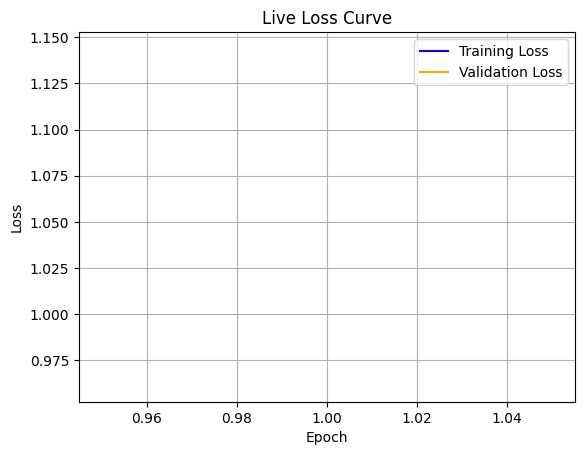

Validation Loss: 0.9617, Accuracy: 0.6130, UAR: 0.5359, F1: 0.5167
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 2/50:  32%|███▏      | 50/154 [00:52<00:40,  2.57it/s, combined_loss=0.463]

Predicted class distribution: {0: 611, 3: 204, 2: 147, 1: 38}


Epoch 2/50:  65%|██████▍   | 100/154 [01:11<00:20,  2.60it/s, combined_loss=0.956]

Predicted class distribution: {2: 229, 0: 485, 3: 196, 1: 90}


Epoch 2/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.28it/s, combined_loss=0.602]

Predicted class distribution: {3: 141, 0: 583, 2: 148, 1: 128}


Epoch 2/50 - Training Loss: 0.8066  


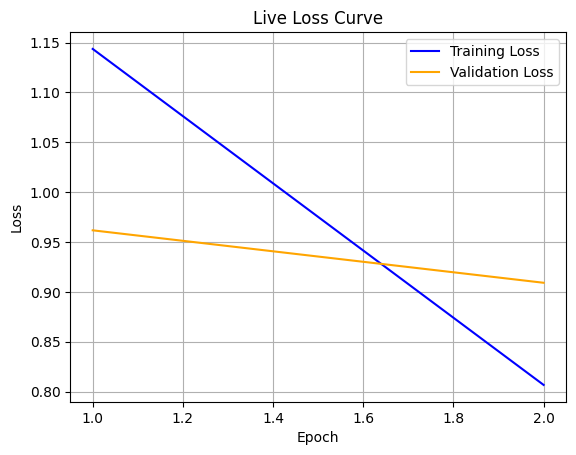

Validation Loss: 0.9091, Accuracy: 0.6796, UAR: 0.6033, F1: 0.6028
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 3/50:  32%|███▏      | 50/154 [00:52<00:42,  2.48it/s, combined_loss=0.687] 

Predicted class distribution: {3: 133, 2: 207, 0: 551, 1: 109}


Epoch 3/50:  65%|██████▍   | 100/154 [01:12<00:23,  2.31it/s, combined_loss=0.645]

Predicted class distribution: {1: 127, 0: 513, 3: 218, 2: 142}


Epoch 3/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.58it/s, combined_loss=0.437]

Predicted class distribution: {0: 447, 1: 131, 2: 226, 3: 196}


Epoch 3/50 - Training Loss: 0.5853  


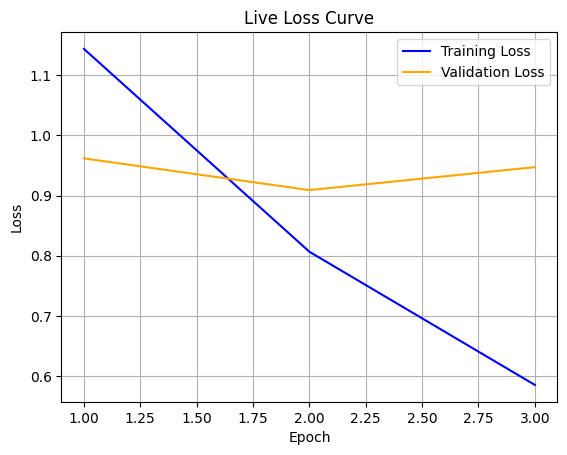

Validation Loss: 0.9472, Accuracy: 0.6759, UAR: 0.6617, F1: 0.6545


Epoch 4/50:  32%|███▏      | 50/154 [00:52<00:37,  2.75it/s, combined_loss=0.614] 

Predicted class distribution: {0: 456, 3: 199, 2: 177, 1: 168}


Epoch 4/50:  65%|██████▍   | 100/154 [01:12<00:21,  2.53it/s, combined_loss=0.278]

Predicted class distribution: {0: 413, 2: 244, 1: 156, 3: 187}


Epoch 4/50:  97%|█████████▋| 150/154 [01:33<00:01,  2.30it/s, combined_loss=0.261]

Predicted class distribution: {3: 187, 0: 520, 2: 182, 1: 111}


Epoch 4/50 - Training Loss: 0.4252  


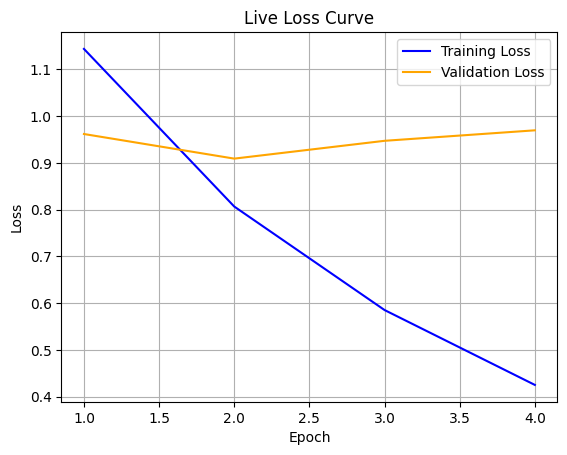

Validation Loss: 0.9696, Accuracy: 0.7037, UAR: 0.6786, F1: 0.6715
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 5/50:  32%|███▏      | 50/154 [00:51<00:40,  2.54it/s, combined_loss=0.237] 

Predicted class distribution: {0: 399, 3: 222, 1: 148, 2: 231}


Epoch 5/50:  65%|██████▍   | 100/154 [01:11<00:21,  2.48it/s, combined_loss=0.207]

Predicted class distribution: {0: 449, 2: 245, 3: 167, 1: 139}


Epoch 5/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.44it/s, combined_loss=0.629] 

Predicted class distribution: {0: 465, 2: 177, 1: 148, 3: 210}


Epoch 5/50 - Training Loss: 0.3340  


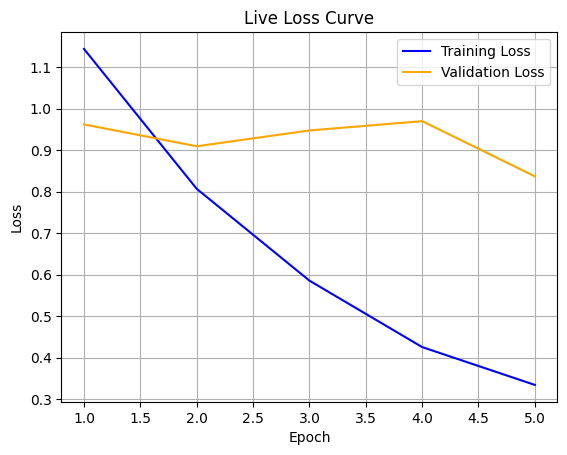

Validation Loss: 0.8365, Accuracy: 0.7148, UAR: 0.6857, F1: 0.6964
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 6/50:  32%|███▏      | 50/154 [00:52<00:44,  2.34it/s, combined_loss=0.207]  

Predicted class distribution: {0: 502, 2: 200, 3: 150, 1: 148}


Epoch 6/50:  65%|██████▍   | 100/154 [01:12<00:20,  2.62it/s, combined_loss=0.207]

Predicted class distribution: {1: 160, 0: 422, 2: 232, 3: 186}


Epoch 6/50:  97%|█████████▋| 150/154 [01:33<00:01,  2.48it/s, combined_loss=0.513] 

Predicted class distribution: {3: 268, 2: 230, 0: 369, 1: 133}


Epoch 6/50 - Training Loss: 0.2386  


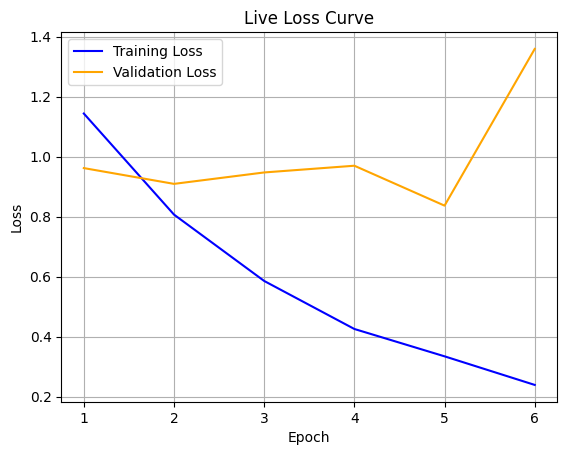

Validation Loss: 1.3592, Accuracy: 0.6907, UAR: 0.6802, F1: 0.6662


Epoch 7/50:  32%|███▏      | 50/154 [00:53<00:42,  2.46it/s, combined_loss=0.0996] 

Predicted class distribution: {3: 243, 2: 251, 0: 366, 1: 140}


Epoch 7/50:  65%|██████▍   | 100/154 [01:14<00:21,  2.51it/s, combined_loss=0.16]  

Predicted class distribution: {3: 201, 2: 192, 0: 460, 1: 147}


Epoch 7/50:  97%|█████████▋| 150/154 [01:34<00:01,  2.20it/s, combined_loss=0.177] 

Predicted class distribution: {3: 194, 2: 254, 1: 136, 0: 416}


Epoch 7/50 - Training Loss: 0.1972  


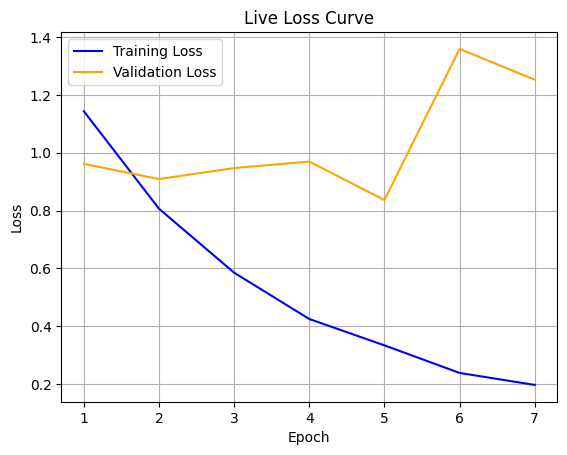

Validation Loss: 1.2527, Accuracy: 0.6944, UAR: 0.6358, F1: 0.6581


Epoch 8/50:  32%|███▏      | 50/154 [00:53<00:40,  2.59it/s, combined_loss=0.00385]

Predicted class distribution: {1: 139, 2: 248, 0: 374, 3: 239}


Epoch 8/50:  65%|██████▍   | 100/154 [01:13<00:21,  2.47it/s, combined_loss=0.456] 

Predicted class distribution: {0: 485, 2: 192, 3: 181, 1: 142}


Epoch 8/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.55it/s, combined_loss=0.081]  

Predicted class distribution: {3: 240, 0: 384, 1: 131, 2: 245}


Epoch 8/50 - Training Loss: 0.1541  


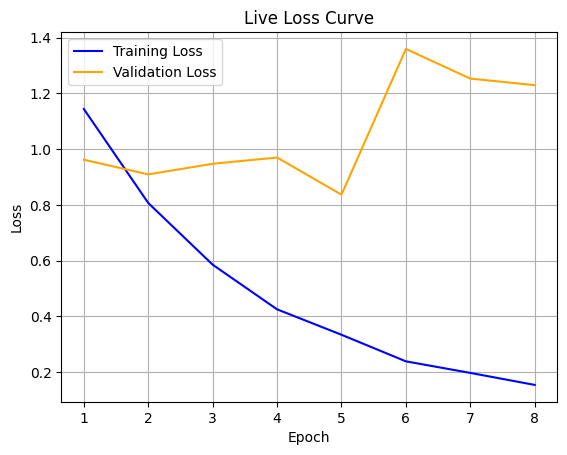

Validation Loss: 1.2292, Accuracy: 0.7037, UAR: 0.6840, F1: 0.6880


Epoch 9/50:  32%|███▏      | 50/154 [00:51<00:41,  2.48it/s, combined_loss=0.0615] 

Predicted class distribution: {2: 283, 0: 385, 1: 148, 3: 184}


Epoch 9/50:  65%|██████▍   | 100/154 [01:11<00:20,  2.61it/s, combined_loss=0.156]  

Predicted class distribution: {0: 453, 2: 236, 3: 184, 1: 127}


Epoch 9/50:  97%|█████████▋| 150/154 [01:31<00:01,  2.57it/s, combined_loss=0.198]  

Predicted class distribution: {0: 396, 2: 185, 3: 283, 1: 136}


Epoch 9/50 - Training Loss: 0.1371  


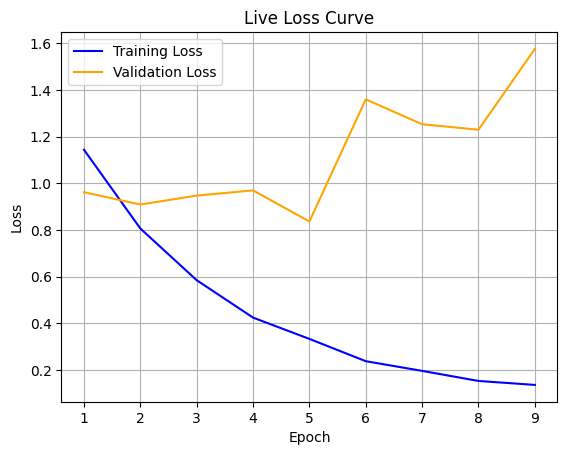

Validation Loss: 1.5750, Accuracy: 0.7222, UAR: 0.7299, F1: 0.7074
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 10/50:  32%|███▏      | 50/154 [00:52<00:38,  2.68it/s, combined_loss=0.00253] 

Predicted class distribution: {2: 234, 1: 137, 0: 441, 3: 188}


Epoch 10/50:  65%|██████▍   | 100/154 [01:12<00:22,  2.44it/s, combined_loss=0.00409]

Predicted class distribution: {0: 435, 1: 152, 3: 173, 2: 240}


Epoch 10/50:  97%|█████████▋| 150/154 [01:31<00:01,  2.60it/s, combined_loss=0.0211]  

Predicted class distribution: {2: 243, 3: 293, 1: 125, 0: 339}


Epoch 10/50 - Training Loss: 0.1193  


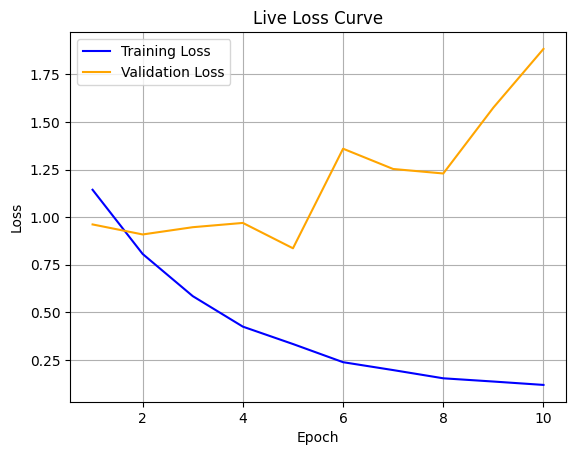

Validation Loss: 1.8830, Accuracy: 0.7352, UAR: 0.7443, F1: 0.7200
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 11/50:  32%|███▏      | 50/154 [00:53<00:42,  2.44it/s, combined_loss=0.00567] 

Predicted class distribution: {0: 374, 1: 140, 2: 259, 3: 227}


Epoch 11/50:  65%|██████▍   | 100/154 [01:14<00:21,  2.46it/s, combined_loss=0.0266] 

Predicted class distribution: {3: 199, 1: 144, 0: 463, 2: 194}


Epoch 11/50:  97%|█████████▋| 150/154 [01:34<00:01,  2.50it/s, combined_loss=0.442]   

Predicted class distribution: {2: 263, 3: 243, 0: 361, 1: 133}


Epoch 11/50 - Training Loss: 0.1068  


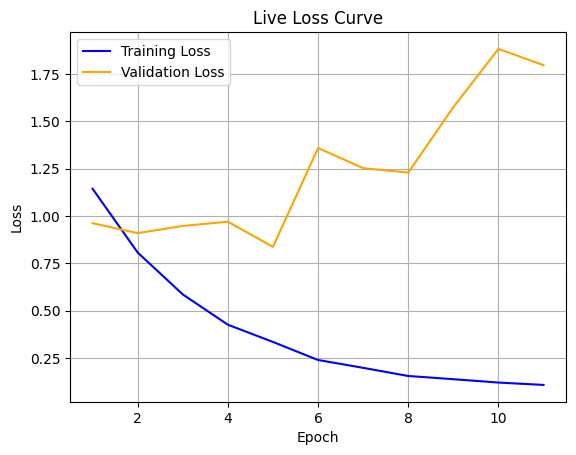

Validation Loss: 1.7973, Accuracy: 0.7352, UAR: 0.7288, F1: 0.7178


Epoch 12/50:  32%|███▏      | 50/154 [00:50<00:39,  2.63it/s, combined_loss=0.182]   

Predicted class distribution: {2: 236, 1: 148, 3: 216, 0: 400}


Epoch 12/50:  65%|██████▍   | 100/154 [01:10<00:22,  2.43it/s, combined_loss=0.000199]

Predicted class distribution: {0: 412, 3: 203, 1: 143, 2: 242}


Epoch 12/50:  97%|█████████▋| 150/154 [01:30<00:01,  2.51it/s, combined_loss=0.242]   

Predicted class distribution: {0: 399, 2: 245, 3: 224, 1: 132}


Epoch 12/50 - Training Loss: 0.1134  


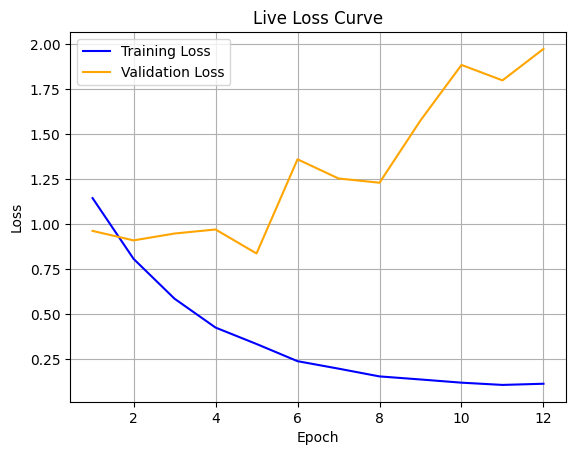

Validation Loss: 1.9719, Accuracy: 0.7185, UAR: 0.7111, F1: 0.7042


Epoch 13/50:  32%|███▏      | 50/154 [00:51<00:40,  2.57it/s, combined_loss=0.0403]  

Predicted class distribution: {1: 153, 0: 330, 3: 238, 2: 279}


Epoch 13/50:  65%|██████▍   | 100/154 [01:11<00:21,  2.51it/s, combined_loss=0.000471]

Predicted class distribution: {1: 135, 0: 468, 3: 183, 2: 214}


Epoch 13/50:  97%|█████████▋| 150/154 [01:32<00:01,  2.49it/s, combined_loss=0.0236]  

Predicted class distribution: {2: 244, 0: 395, 3: 224, 1: 137}


Epoch 13/50 - Training Loss: 0.0871  


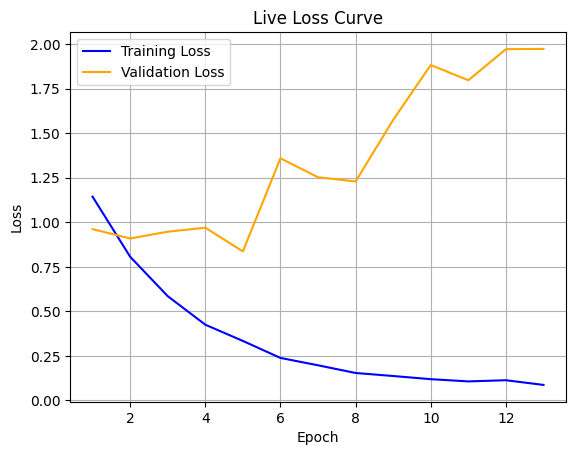

Validation Loss: 1.9732, Accuracy: 0.7333, UAR: 0.7094, F1: 0.7123


Epoch 14/50:  32%|███▏      | 50/154 [00:54<00:43,  2.39it/s, combined_loss=0.447]   

Predicted class distribution: {3: 241, 0: 389, 2: 215, 1: 155}


Epoch 14/50:  65%|██████▍   | 100/154 [01:14<00:22,  2.39it/s, combined_loss=0.0443] 

Predicted class distribution: {3: 191, 2: 250, 0: 424, 1: 135}


Epoch 14/50:  97%|█████████▋| 150/154 [01:35<00:01,  2.51it/s, combined_loss=1.1]     

Predicted class distribution: {1: 142, 0: 376, 3: 219, 2: 263}


Epoch 14/50 - Training Loss: 0.0935  


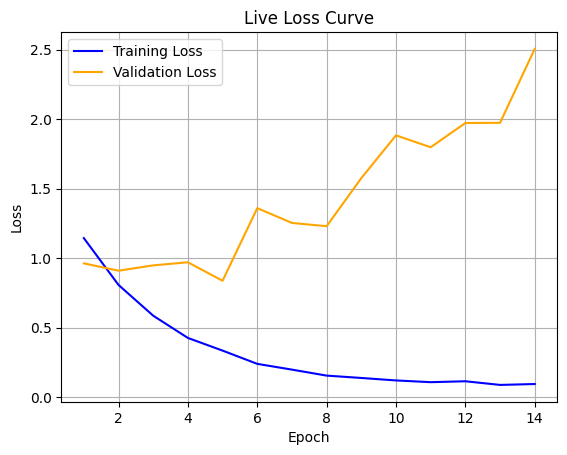

Validation Loss: 2.5049, Accuracy: 0.7204, UAR: 0.7144, F1: 0.6969


Epoch 15/50:  32%|███▏      | 50/154 [00:54<00:42,  2.44it/s, combined_loss=0.0504]   

Predicted class distribution: {2: 230, 3: 253, 1: 142, 0: 375}


Epoch 15/50:  65%|██████▍   | 100/154 [01:14<00:23,  2.31it/s, combined_loss=0.53]   

Predicted class distribution: {0: 432, 2: 229, 1: 150, 3: 189}


Epoch 15/50:  97%|█████████▋| 150/154 [01:35<00:01,  2.46it/s, combined_loss=0.187]   

Predicted class distribution: {3: 212, 2: 262, 1: 126, 0: 400}


Epoch 15/50 - Training Loss: 0.0822  


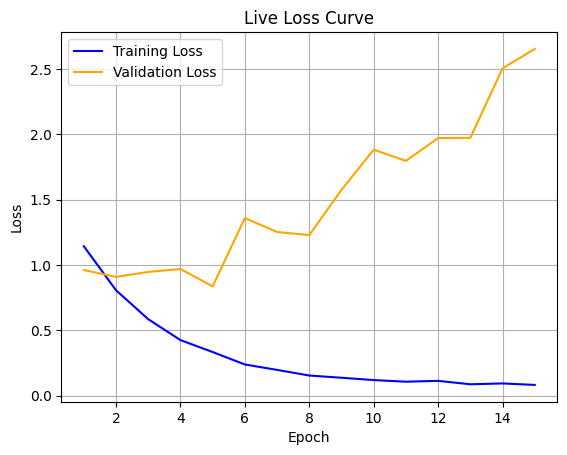

Validation Loss: 2.6542, Accuracy: 0.7093, UAR: 0.7223, F1: 0.6952


Epoch 16/50:  32%|███▏      | 50/154 [00:55<00:42,  2.42it/s, combined_loss=0.162]   

Predicted class distribution: {3: 264, 0: 392, 2: 201, 1: 143}


Epoch 16/50:  65%|██████▍   | 100/154 [01:16<00:23,  2.26it/s, combined_loss=1.1e-7] 

Predicted class distribution: {3: 172, 1: 140, 0: 471, 2: 217}


Epoch 16/50:  97%|█████████▋| 150/154 [01:36<00:01,  2.48it/s, combined_loss=0.168]   

Predicted class distribution: {3: 220, 2: 303, 1: 143, 0: 334}


Epoch 16/50 - Training Loss: 0.0746  


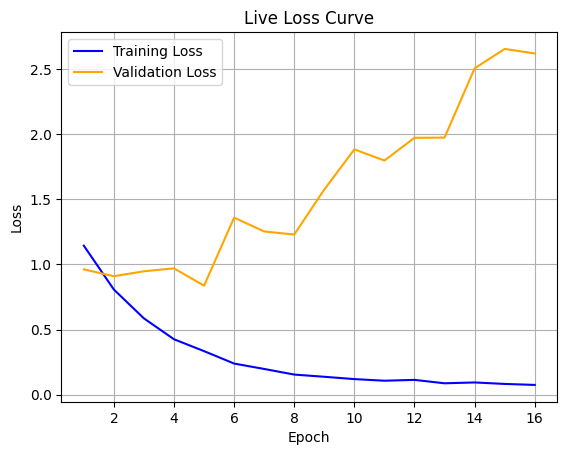

Validation Loss: 2.6192, Accuracy: 0.7204, UAR: 0.7314, F1: 0.7094


Epoch 17/50:  32%|███▏      | 50/154 [00:54<00:43,  2.41it/s, combined_loss=0.111]   

Predicted class distribution: {2: 254, 1: 167, 3: 190, 0: 389}


Epoch 17/50:  65%|██████▍   | 100/154 [01:14<00:22,  2.40it/s, combined_loss=0.00787]

Predicted class distribution: {3: 245, 0: 376, 2: 245, 1: 134}


Epoch 17/50:  97%|█████████▋| 150/154 [01:35<00:01,  2.45it/s, combined_loss=1.78e-6] 

Predicted class distribution: {0: 440, 2: 228, 1: 118, 3: 214}


Epoch 17/50 - Training Loss: 0.0681  


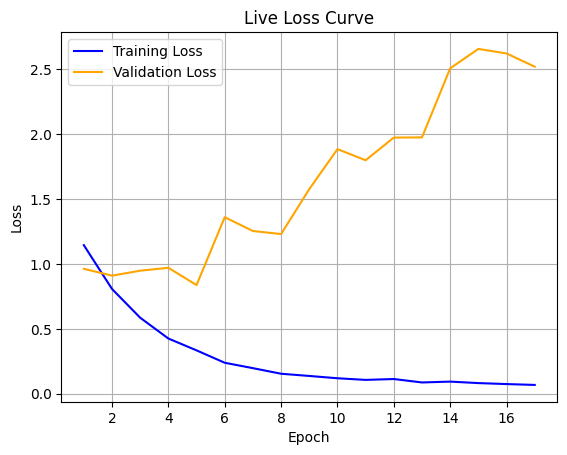

Validation Loss: 2.5174, Accuracy: 0.7259, UAR: 0.7212, F1: 0.7078


Epoch 18/50:  32%|███▏      | 50/154 [00:55<00:39,  2.62it/s, combined_loss=0.000243]

Predicted class distribution: {0: 452, 3: 186, 1: 147, 2: 215}


Epoch 18/50:  65%|██████▍   | 100/154 [01:15<00:23,  2.28it/s, combined_loss=0.000462]

Predicted class distribution: {2: 250, 3: 219, 0: 385, 1: 146}


Epoch 18/50:  97%|█████████▋| 150/154 [01:36<00:01,  2.46it/s, combined_loss=9.65e-5] 

Predicted class distribution: {2: 262, 3: 258, 0: 350, 1: 130}


Epoch 18/50 - Training Loss: 0.0765  


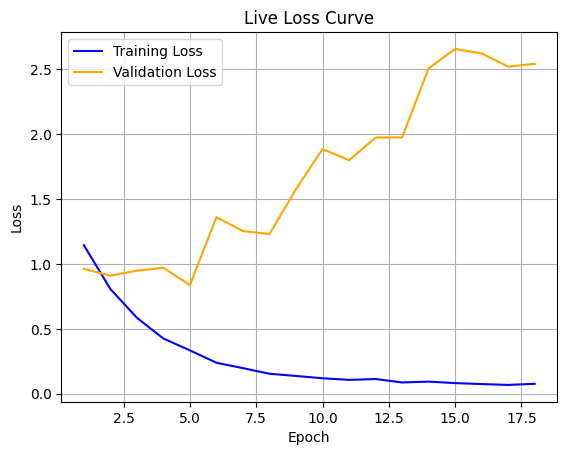

Validation Loss: 2.5398, Accuracy: 0.7222, UAR: 0.7162, F1: 0.7045


Epoch 19/50:  32%|███▏      | 50/154 [00:54<00:41,  2.52it/s, combined_loss=0.000387] 

Predicted class distribution: {2: 231, 0: 374, 3: 269, 1: 126}


Epoch 19/50:  65%|██████▍   | 100/154 [01:15<00:22,  2.45it/s, combined_loss=7.95e-7]

Predicted class distribution: {3: 230, 0: 423, 1: 151, 2: 196}


Epoch 19/50:  97%|█████████▋| 150/154 [01:35<00:01,  2.36it/s, combined_loss=0.173]   

Predicted class distribution: {2: 308, 0: 370, 3: 170, 1: 152}


Epoch 19/50 - Training Loss: 0.0701  


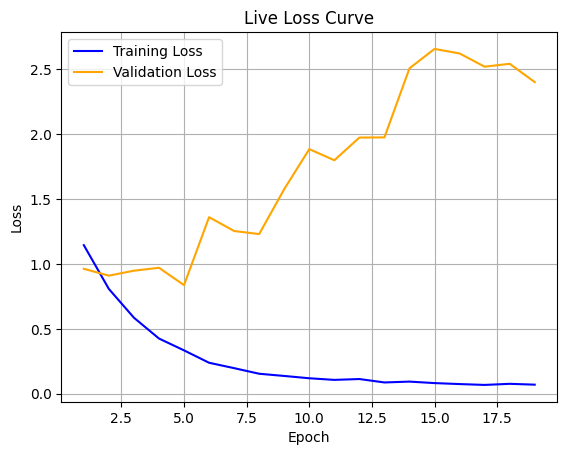

Validation Loss: 2.3986, Accuracy: 0.7389, UAR: 0.7165, F1: 0.7185
Validation accuracy improved. Saving best model and resetting patience counter.


Epoch 20/50:  32%|███▏      | 50/154 [00:55<00:42,  2.43it/s, combined_loss=0.121]   

Predicted class distribution: {2: 264, 0: 405, 1: 153, 3: 178}


Epoch 20/50:  65%|██████▍   | 100/154 [01:15<00:23,  2.30it/s, combined_loss=3.26e-7]

Predicted class distribution: {0: 407, 3: 202, 2: 265, 1: 126}


Epoch 20/50:  97%|█████████▋| 150/154 [01:36<00:01,  2.32it/s, combined_loss=0.506]   

Predicted class distribution: {0: 366, 3: 275, 2: 218, 1: 141}


Epoch 20/50 - Training Loss: 0.0794  


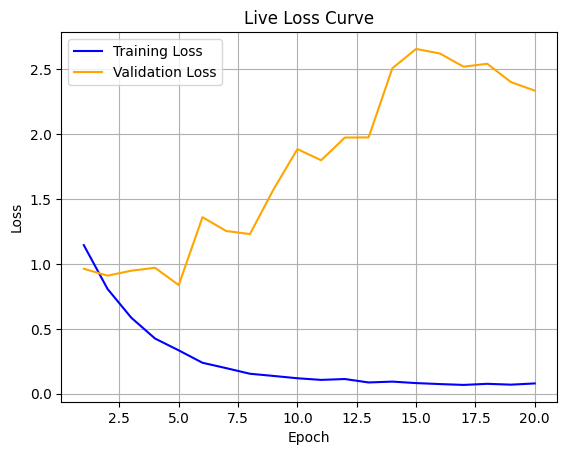

Validation Loss: 2.3331, Accuracy: 0.7111, UAR: 0.6505, F1: 0.6748


Epoch 21/50:  32%|███▏      | 50/154 [00:54<00:40,  2.55it/s, combined_loss=0.000111]

Predicted class distribution: {0: 406, 2: 219, 3: 234, 1: 141}


Epoch 21/50:  65%|██████▍   | 100/154 [01:14<00:23,  2.34it/s, combined_loss=0.0586] 

Predicted class distribution: {3: 195, 0: 422, 1: 151, 2: 232}


Epoch 21/50:  97%|█████████▋| 150/154 [01:34<00:01,  2.42it/s, combined_loss=0.0484]  

Predicted class distribution: {2: 275, 1: 127, 0: 357, 3: 241}


Epoch 21/50 - Training Loss: 0.0656  


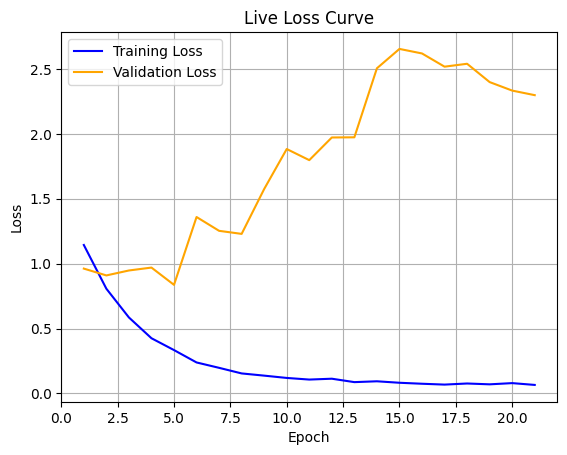

Validation Loss: 2.2979, Accuracy: 0.7370, UAR: 0.7309, F1: 0.7259


KeyboardInterrupt: 

In [26]:
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Enable interactive mode
%matplotlib notebook

# Initialize lists to store loss values
train_losses = []
val_losses = []
epochs_list = []

# Create the figure and axis for the plot
fig, ax = plt.subplots()
train_line, = ax.plot([], [], label="Training Loss", color='blue')
val_line, = ax.plot([], [], label="Validation Loss", color='orange')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Live Loss Curve")
ax.legend()
ax.grid()


# Directory to save the best model
best_model_path = os.path.join(output_dir,"best_model.pt")

# Training loop with Early Stopping
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    bert_train_loss = 0
    img_train_loss = 0
    all_trained_preds = []
    i = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch in progress_bar:
        i += 1
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)


        # bert_embeddings = batch["bert_embeddings"].to(device)


        # Forward pass
        # Forward pass
        # outputs = model(pixel_values=pixel_values, bert_embeddings=bert_embeddings)

        outputs = model(pixel_values=pixel_values, bert_input_ids=input_ids, bert_attention_mask=attention_mask)

        logits = outputs["logits"]
        # image_logits = outputs["image_logits"]
        # bert_logits = outputs["bert_logits"]

        # image_loss = focal_loss(image_logits, labels)  # Loss for image features only
        # bert_loss = focal_loss(bert_logits, labels)  # Loss for BERT features only

        # Compute Focal Loss for each
        combined_loss = focal_loss(logits, labels)  # Loss for combined features
        # weight = max(0.1, 1 - epoch * 0.02)  # Decrease weight over time
        # combined_loss = weight * image_loss + (1 - weight) * combined_loss



        # # Separate optimizers
        # optimizer_image = torch.optim.Adam(model.image_model.parameters(), lr=1e-5)
        # optimizer_bert = torch.optim.Adam(model.bert_model.parameters(), lr=1e-4)
        optimizer_combined = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)


        # # Update both models using the combined loss
        # torch.autograd.set_detect_anomaly(True)
        # optimizer_image.zero_grad()
        # image_loss.backward(retain_graph=True)  # Retain graph to allow further backpropagation
        # optimizer_bert.step()

        
        optimizer_combined.zero_grad()
        combined_loss.backward()
        optimizer_combined.step()
        # optimizer_image.step()

        # Step the learning rate scheduler for the combined optimizer

        # Update progress bar
        train_loss += combined_loss.item()
        # img_train_loss += image_loss.item()
        # bert_train_loss += bert_loss.item()

        progress_bar.set_postfix({"combined_loss": combined_loss.item()}) #, "image_loss": image_loss.item(),"bert_loss": bert_loss.item(),})

        predictions = torch.argmax(logits, dim=-1)
        all_trained_preds.extend(predictions.cpu().numpy())

        # Class distribution every 50 batches
        if i % 50 == 0:
            class_counts = Counter(all_trained_preds)
            clean_class_counts = {int(k): v for k, v in class_counts.items()}
            print("Predicted class distribution:", clean_class_counts)
            all_trained_preds = []
        
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader):.4f}  ")#Img Loss: {img_train_loss / len(train_loader):.4f}  Bert Loss: {bert_train_loss / len(train_loader):.4f} ")
    lr_scheduler.step()

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []


    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            bert_embeddings = batch["bert_embeddings"].to(device)


            # Forward pass
            # outputs = model(pixel_values=pixel_values, bert_embeddings=bert_embeddings)
            outputs = model(pixel_values=pixel_values, bert_input_ids=input_ids, bert_attention_mask=attention_mask)

            logits = outputs["logits"]

            # Compute Focal Loss
            loss = focal_loss(logits, labels)
            val_loss += loss.item()

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    uar = recall_score(all_labels, all_predictions, average="macro")
    f1 = f1_score(all_labels, all_predictions, average="macro")

        # Append loss values
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(avg_val_loss)
    epochs_list.append(epoch + 1)

    # Update the data for the plot
    train_line.set_data(epochs_list, train_losses)
    val_line.set_data(epochs_list, val_losses)

    # Adjust the axis limits
    ax.relim()
    ax.autoscale_view()

    # Display the updated plot
    # clear_output(wait=True)
    display(fig)

    # Optionally add a pause to control update speed (e.g., 0.1 seconds)
    plt.pause(0.1)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, UAR: {uar:.4f}, F1: {f1:.4f}")


    # Early stopping logic based on UAR
    if accuracy>best_val_uar:
        best_val_uar = accuracy
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), best_model_path)
        print("Validation accuracy improved. Saving best model and resetting patience counter.")
    else:
        patience_counter += 1

    # Check if we should stop early
    if patience_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break



plt.show()



In [27]:
# Load the best model after training is complete
print("Loading best model for final evaluation.")
model.load_state_dict(torch.load(best_model_path))


Loading best model for final evaluation.


/tmp/ipykernel_3640134/1112781903.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [ ]:
# old_model = "/media/carol/Data/Documents/Emo_rec/Notebooks/NLP_IMG/Ver1/DinatBert/manual_trained_model.pth"

# model.load_state_dict(torch.load(old_model))

In [ ]:
os.makedirs(output_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(output_dir, "manual_trained_model.pth"))
print("Model saved successfully.")


In [28]:
model.to(device)

# Test Loop
print("\nStarting Test Evaluation...")
model.eval()
test_loss = 0
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    # Progress bar for testing
    test_progress_bar = tqdm(test_loader, desc="Testing", leave=False)
    for batch in test_progress_bar:
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        bert_embeddings = batch["bert_embeddings"].to(device)
       
        outputs = model(pixel_values=pixel_values, bert_input_ids=input_ids, bert_attention_mask=attention_mask)        
        logits = outputs["logits"]
        # Compute loss
        loss = F.cross_entropy(logits, labels)
        test_loss += loss.item()

        # Get predictions
        predictions = torch.argmax(logits, dim=-1)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
test_uar = recall_score(all_test_labels, all_test_predictions, average="macro")
test_f1 = f1_score(all_test_labels, all_test_predictions, average="macro")

print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, UAR: {test_uar:.4f}, F1: {test_f1:.4f}")

metrics = f"Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, UAR: {test_uar:.4f}, F1: {test_f1:.4f}"


Starting Test Evaluation...


Test Loss: 1.4527, Accuracy: 0.7327, UAR: 0.7246, F1: 0.7018


In [ ]:
metrics

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np
import os

# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_predictions)
classes = np.unique(all_test_labels)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save the plot
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(save_path, bbox_inches="tight", dpi=300)
# plt.close()  # Close the figure to free up memory
plt.show()

print(f"Confusion matrix saved to: {save_path}")


<IPython.core.display.Javascript object>

Confusion matrix saved to: ./models/confusion_matrix.png


In [ ]:
class_weights

In [ ]:
classes

In [ ]:

# Define output paths and parameters
# output_dir = "./logs"
pathstr = model_path
model_type = "CombinedModel"
dataset_name = 'cairocode/IEMOCAP_IMG_NLP'
speaker_disentanglement = False  # Update this based on your configuration
entropy = False  # Update based on your configuration
column = "label"
speakers = [945]
angry_weight = 0.92
happy_weight = 1.3
neutral_weight = 0.85
sad_weight = 1.0
weight_decay = training_args.weight_decay

# Save metadata after training
save_training_metadata(
    output_dir=output_dir,
    pathstr=pathstr,
    dataset_name=dataset_name,
    model_type=model_type,
    super_loss_params=super_loss_params,
    speaker_disentanglement=speaker_disentanglement,
    entropy=entropy,
    column=column,
    metrics=metrics,
    speakers=speakers,
    angry_weight=angry_weight,
    happy_weight=happy_weight,
    neutral_weight=neutral_weight,
    sad_weight=sad_weight,
    weight_decay=weight_decay,
    results= metrics

)